In [54]:
from settrade_scraping import settrade_scraping
import pandas as pd
import random
import matplotlib.pyplot as plt
from mplfinance.original_flavor  import candlestick_ohlc 
import matplotlib.dates as mpl_dates 

symbol = "TDEX"
header, data = settrade_scraping(symbol=symbol)
data = data[::-1]
df = pd.DataFrame(data, columns=header)
# df = df.reindex(index=df.index[::-1])
df

,วันที่,ราคาเปิด,ราคาสูงสุด,ราคาต่ำสุด,ราคาเฉลี่ย,ราคาปิด,เปลี่ยนแปลง,เปลี่ยนแปลง (%)
0,2024-03-01,8.10,8.14,8.07,8.09,8.07,-0.02,-0.25
1,2024-03-04,8.07,8.11,8.06,8.08,8.08,+0.01,+0.12
2,2024-03-05,8.05,8.05,7.99,8.02,8.02,-0.06,-0.74
3,2024-03-06,8.05,8.12,8.02,8.09,8.10,+0.08,+1.00
4,2024-03-07,8.10,8.12,8.07,8.10,8.08,-0.02,-0.25
...,...,...,...,...,...,...,...,...
115,2024-08-26,8.38,8.44,8.33,8.39,8.41,+0.07,+0.84
116,2024-08-27,8.42,8.45,8.41,8.43,8.43,+0.02,+0.24
117,2024-08-28,8.45,8.50,8.40,8.45,8.46,+0.03,+0.36
118,2024-08-29,8.45,8.46,8.40,8.44,8.40,-0.06,-0.71


In [55]:
total_days = len(data)
init_capital = 1000
profitability = 0.85
init_invest_size = 1
multiplier = 2 # According to martingale strategy
    
def try_invest():
    capital_list = []
    call_state_list = []
    current_order_side = None
    current_invest_size = init_invest_size
    capital = init_capital
    
    for i in range(total_days):
        if current_order_side == "CALL":
            if float(df["ราคาปิด"][i]) > float(df["ราคาปิด"][i-1]):
                capital += current_invest_size * (1 + profitability)
                current_invest_size = init_invest_size
            else:
                current_invest_size *= multiplier
        elif current_order_side == "PUT":
            if float(df["ราคาปิด"][i]) < float(df["ราคาปิด"][i-1]):
                capital += current_invest_size * (1 + profitability)
                current_invest_size = init_invest_size
            else:
                current_invest_size *= multiplier
        
        capital_list.append(capital)
        
        if i == total_days - 1: # LAST DAY CONDITION, SO DO NOT ORDER MORE
            break
        ## 50-50 Scenario
        # if random.random() < 0.5:
        #     # CALL
        #     current_order_side = "CALL"
        # else:
        #     # PUT
        #     current_order_side = "PUT"
            
        ## Not 50-50 Scenario
        if random.random() < 0.5 + float(df["เปลี่ยนแปลง (%)"][i])/100:
            # CALL
            current_order_side = "CALL"
        else:
            # PUT
            current_order_side = "PUT"
            
        if capital == 0:
            break
        elif current_invest_size > capital:
            current_invest_size = capital
            capital = 0
        else:
            capital -= current_invest_size
        call_state_list.append(current_order_side)
        
    capital_list.extend([capital]*(total_days-len(capital_list)))
    call_state_list.extend(["-"]*(total_days-len(call_state_list)))
    return capital_list, capital > init_capital, call_state_list

Text(0.5, 0, 'Number of Days (Steps)')

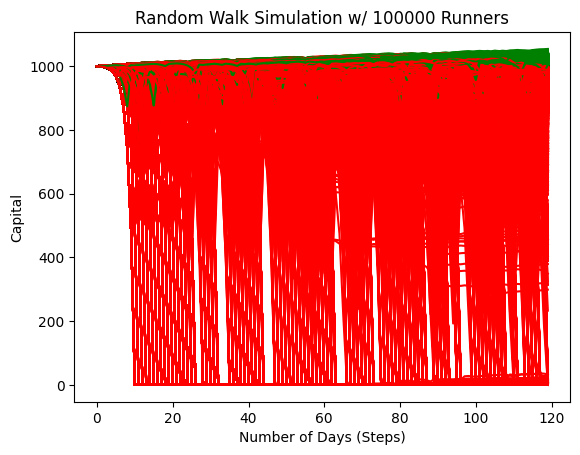

In [56]:
N = 100000 # number of runner
result_capital_list = []
best_result = []
worst_result = []
random.seed(42)
for _ in range(N):
    result, isProfit, call_state_list = try_invest()
    result_capital_list.append(result[-1])
    if result[-1] == max(result_capital_list):
        best_guess = call_state_list
        best_result = resultS
    if result[-1] == min(result_capital_list):
        worst_guess = call_state_list
        worst_result = result
    # plt.plot(range(total_days),result)
    plt.plot(range(total_days),result, color='g' if isProfit else 'r')
plt.title(f"Random Walk Simulation w/ {N} Runners")
plt.ylabel("Capital")
plt.xlabel("Number of Days (Steps)")

Text(0, 0.5, 'Number of Runner')

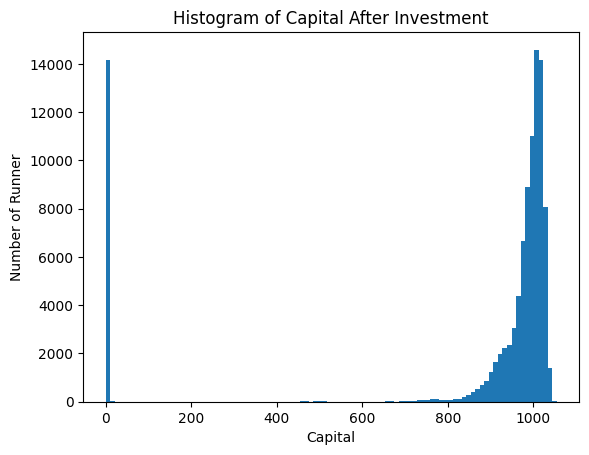

In [57]:
plt.hist(result_capital_list,bins=100)
plt.title("Histogram of Capital After Investment")
plt.xlabel("Capital")
plt.ylabel("Number of Runner")

In [58]:
print("Number of Runner Profits: ", len([x for x in result_capital_list if x > init_capital]))
print("Number of Runner Losses: ", len([x for x in result_capital_list if x < init_capital]))
print("Profit Ratio: ", len([x for x in result_capital_list if x > init_capital])/N)
print("Mean of Final Capital: ", sum(result_capital_list)/len(result_capital_list))

Number of Runner Profits:  39831
Number of Runner Losses:  60169
Profit Ratio:  0.39831
Mean of Final Capital:  843.9792752590117


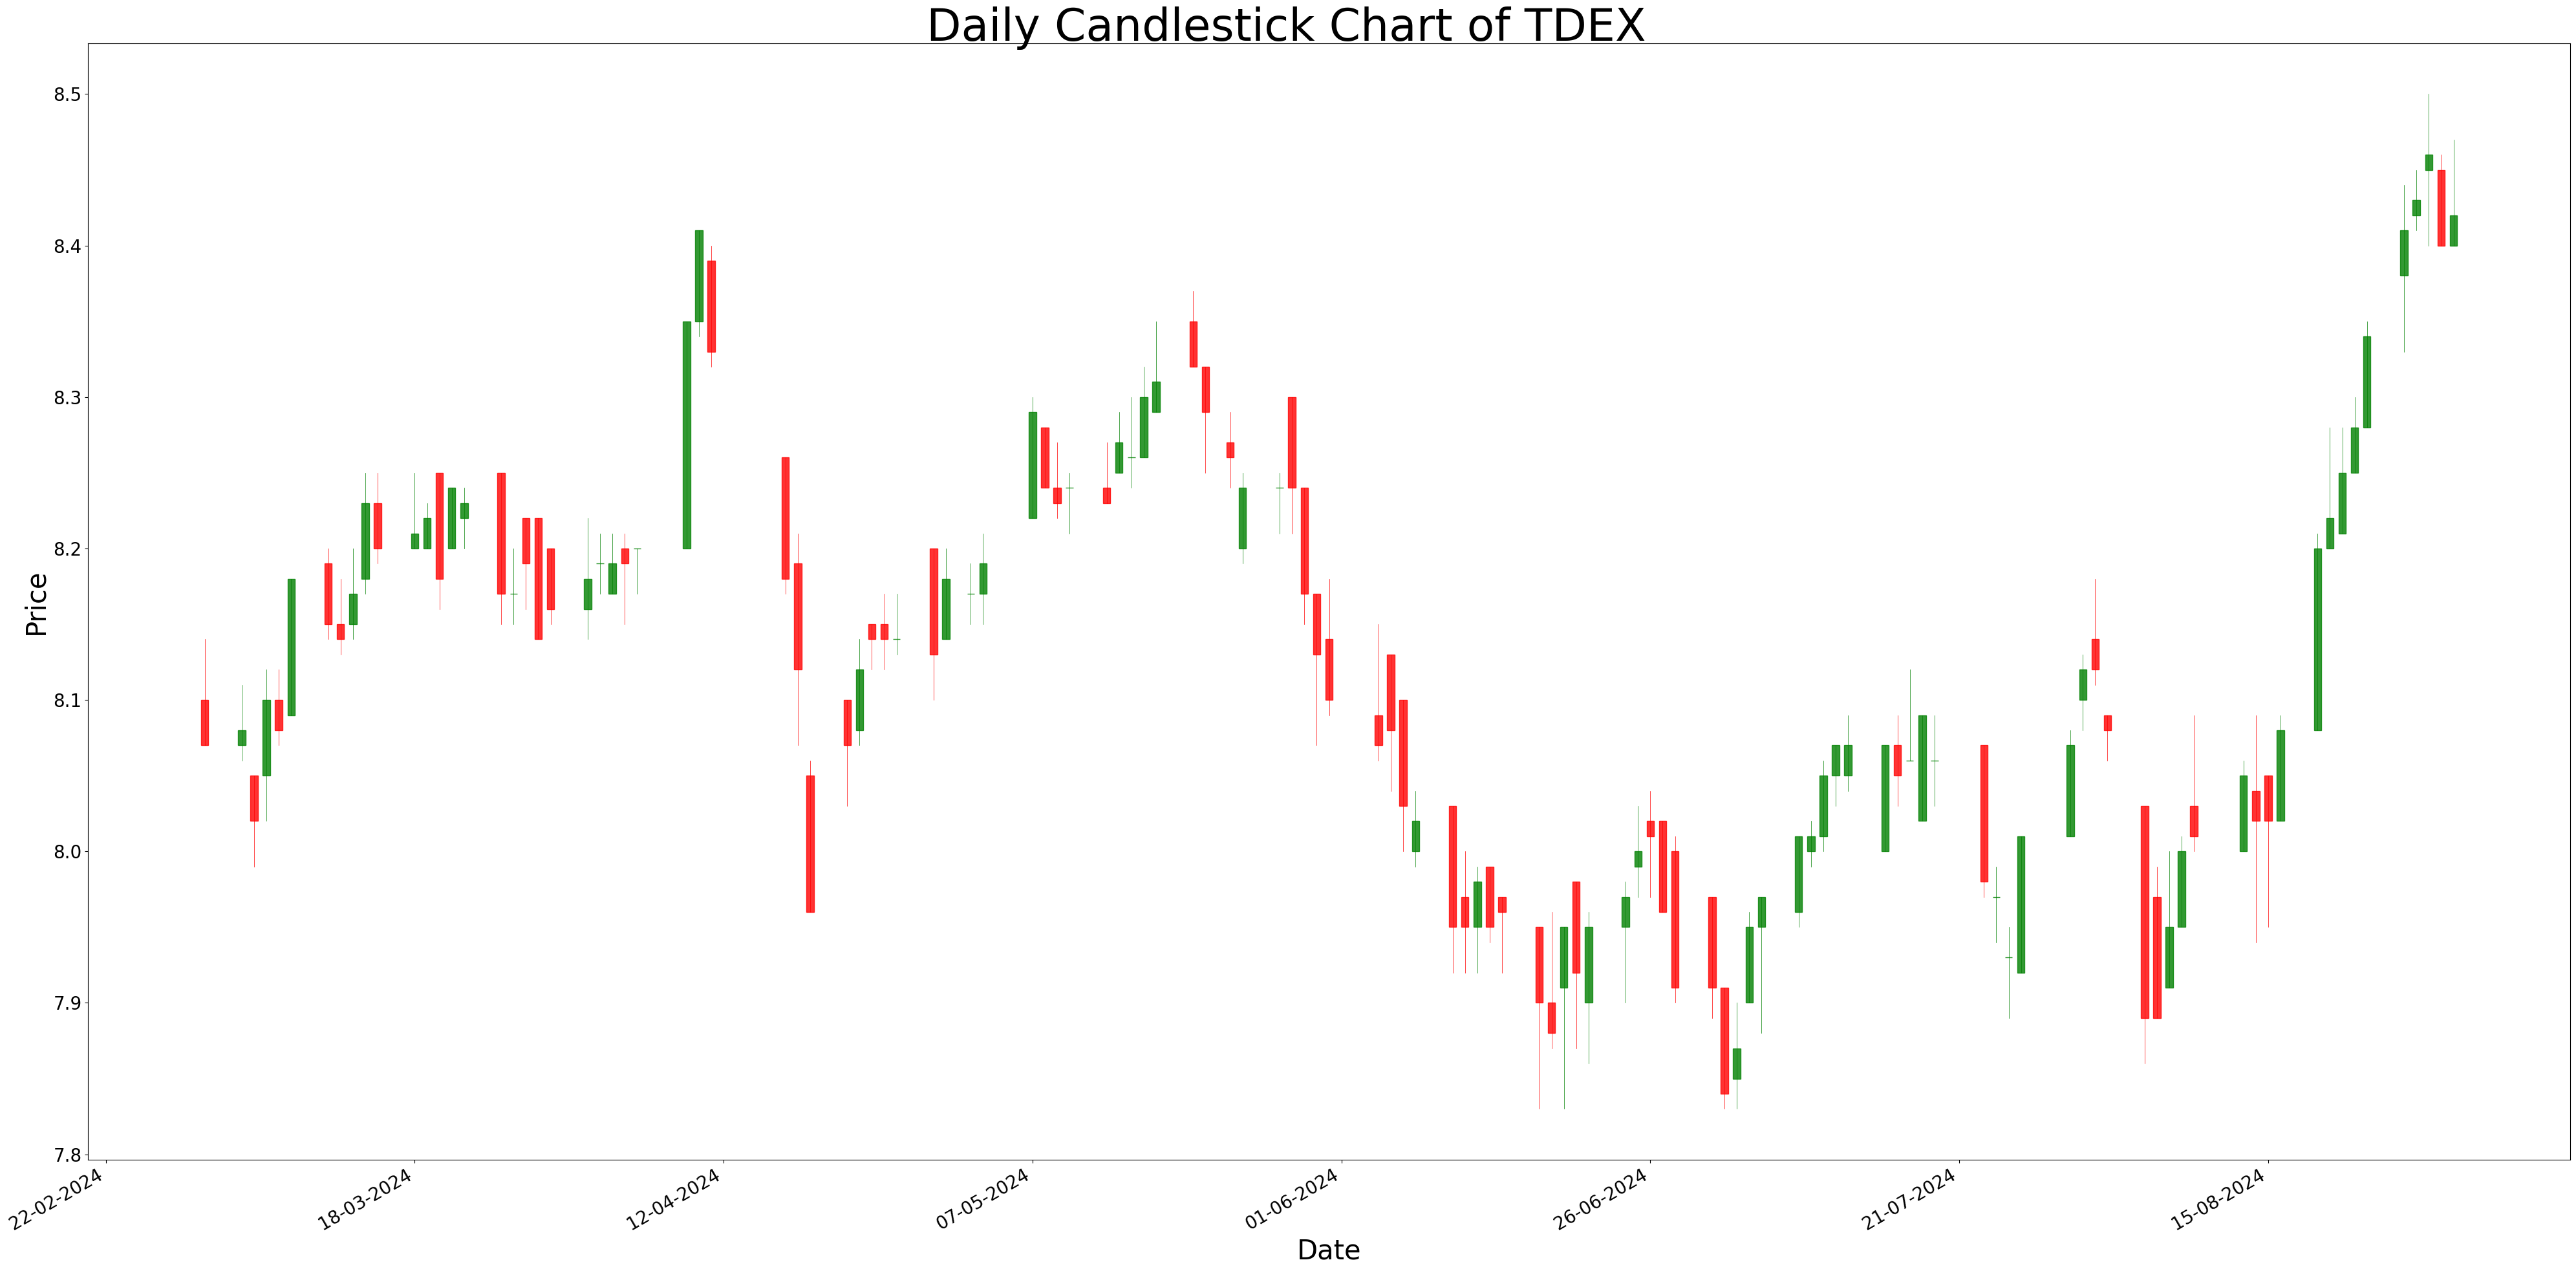

In [59]:
# Extracting Data for plotting 
ohlc = df.loc[:, ['วันที่', 'ราคาเปิด', 'ราคาสูงสุด', 'ราคาต่ำสุด', 'ราคาปิด']] 
  
# Converting date into datetime format 
ohlc['วันที่'] = pd.to_datetime(ohlc['วันที่']) 
ohlc['วันที่'] = ohlc['วันที่'].apply(mpl_dates.date2num) 
ohlc = ohlc.astype(float) 
  
# Creating Subplots 
fig, ax = plt.subplots(figsize=(40, 20), dpi=100) 
  
candlestick_ohlc(ax, ohlc.values, width=0.6, 
                 colorup='green', colordown='red', alpha=0.8) 
  
# Setting labels & titles 
ax.set_xlabel('Date', fontsize=30) 
ax.set_ylabel('Price', fontsize=30) 
fig.suptitle(f'Daily Candlestick Chart of {symbol}', fontsize=50) 
  
# Formatting Date 
date_format = mpl_dates.DateFormatter('%d-%m-%Y') 
ax.xaxis.set_major_formatter(date_format) 
fig.autofmt_xdate() 
  
ax.tick_params(axis='x', labelsize=20)  # X-axis tick labels
ax.tick_params(axis='y', labelsize=20)  # Y-axis tick labels

fig.tight_layout() 
  
plt.show() 

Text(0, 0.5, 'Capital')

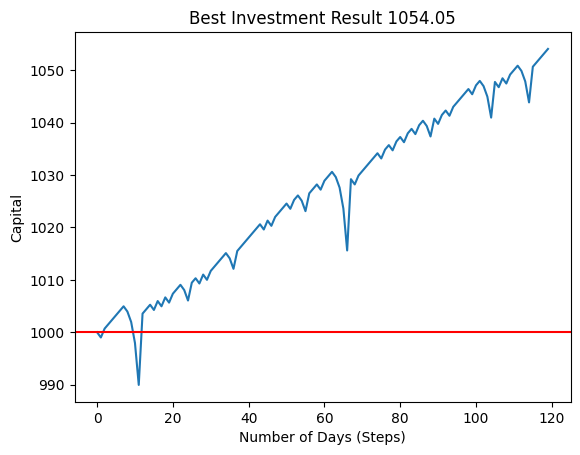

In [66]:
plt.plot(range(total_days),best_result)
plt.axhline(y=init_capital, color='r', linestyle='-')
plt.title(f"Best Investment Result {max(result_capital_list):.2f}")
plt.xlabel("Number of Days (Steps)")
plt.ylabel("Capital")

In [61]:
max(result_capital_list)

1054.049999999999

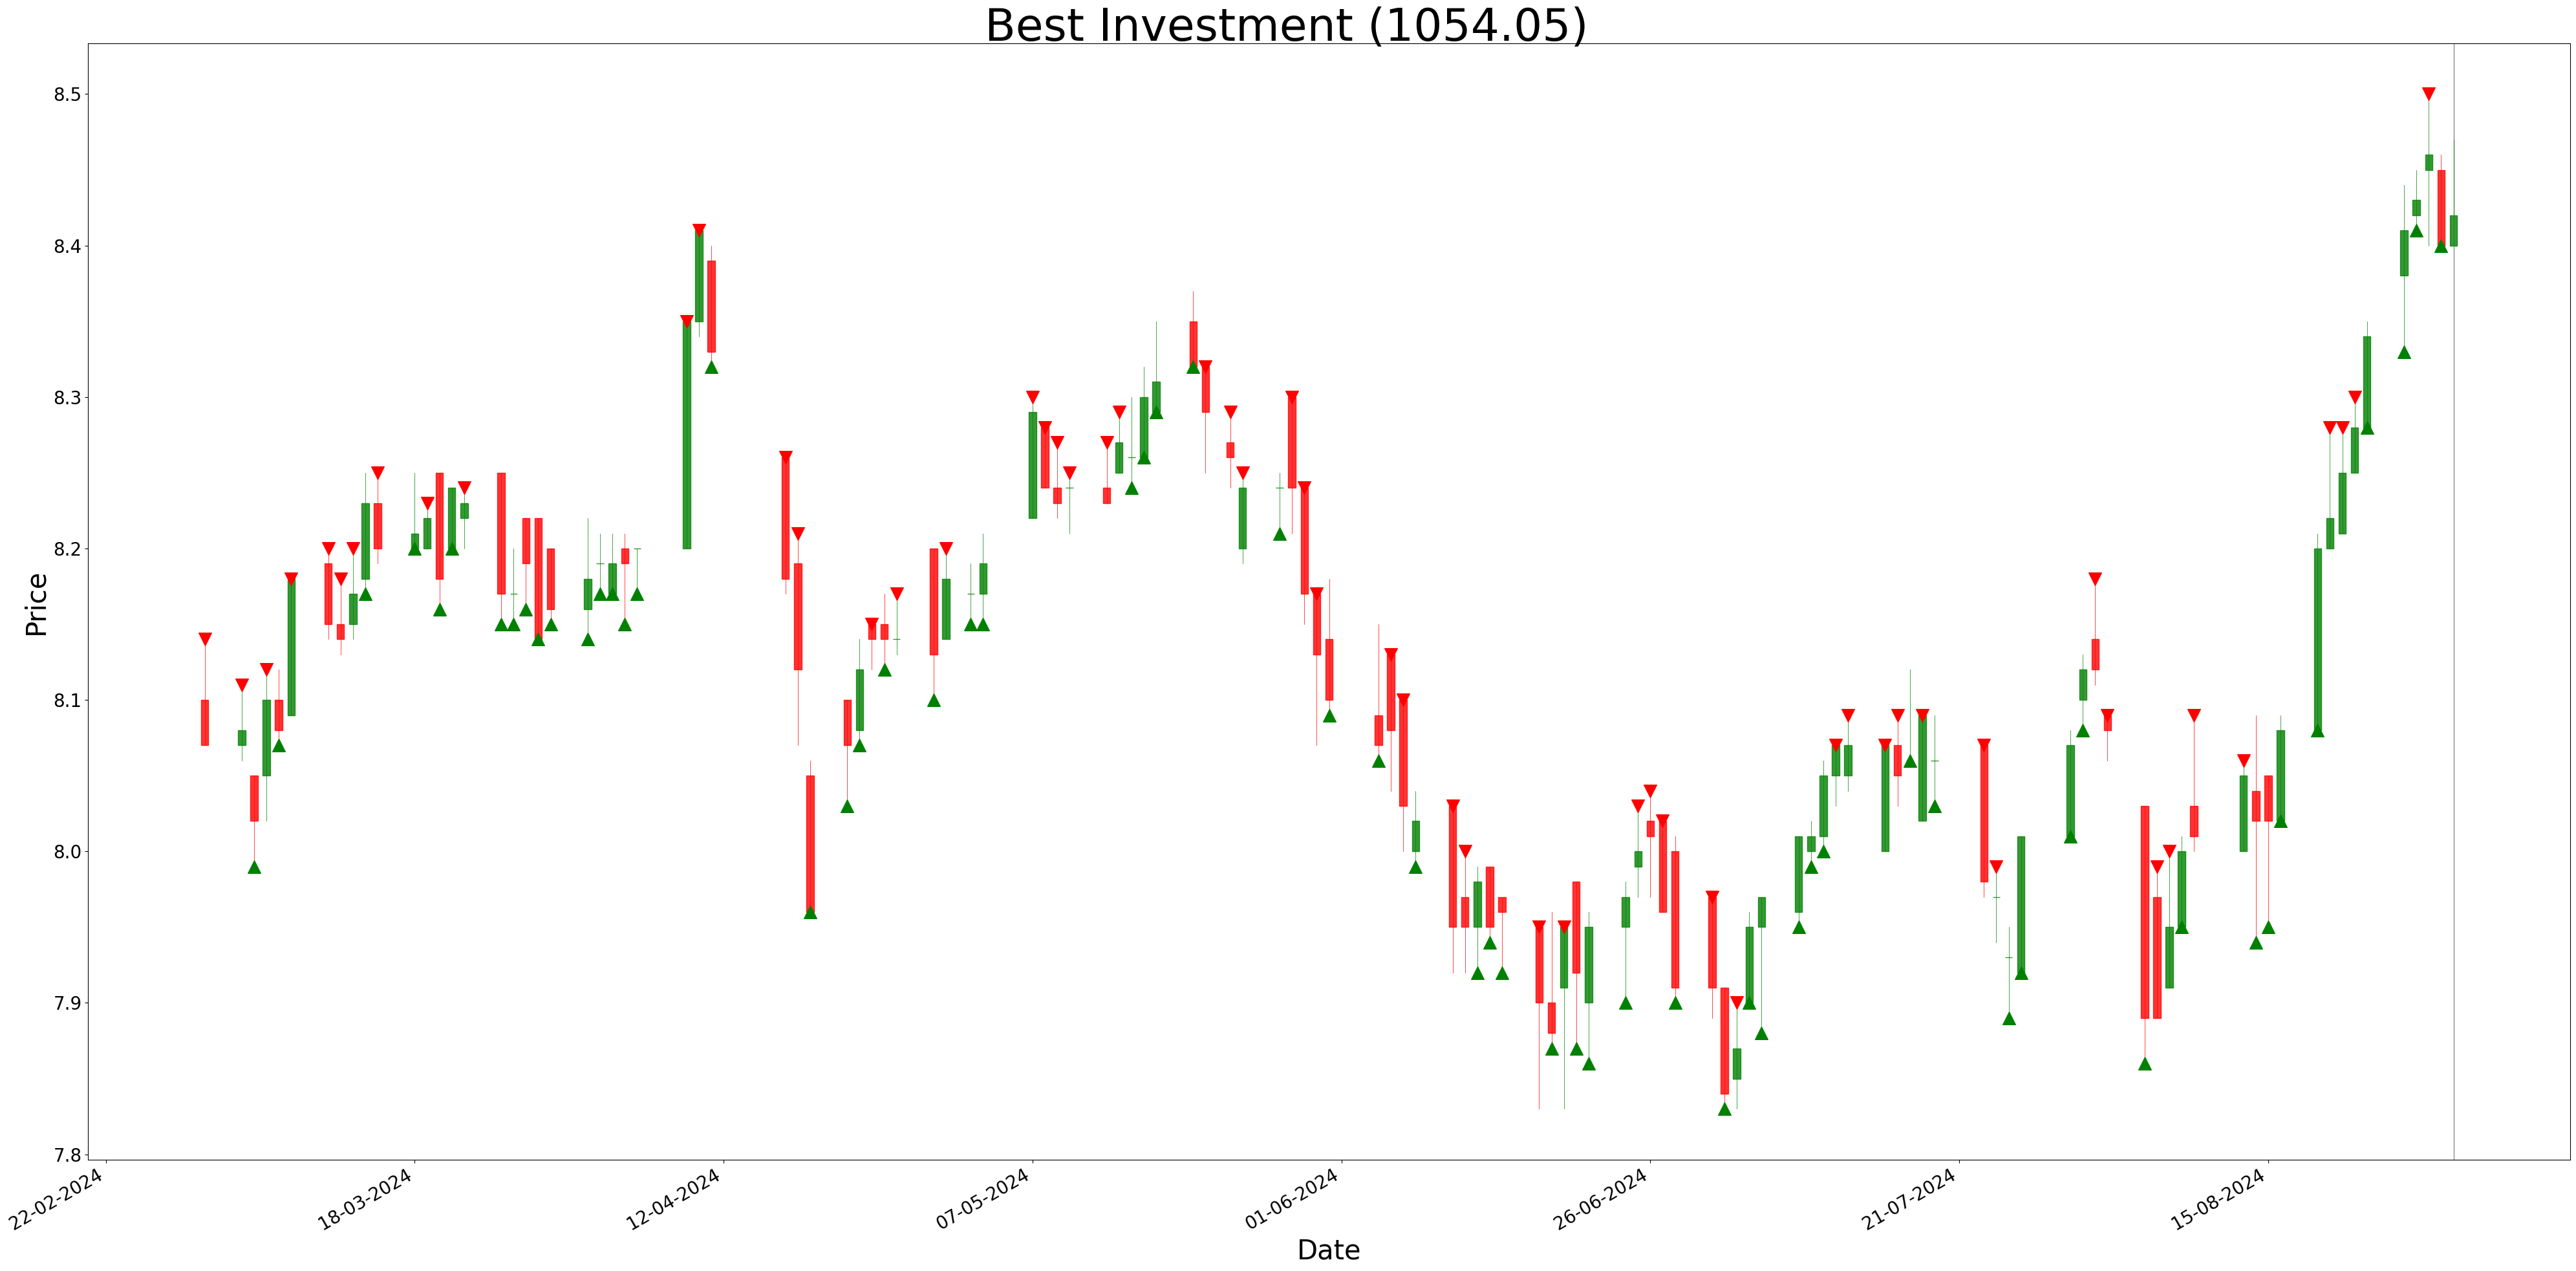

In [62]:
fig, ax = plt.subplots(figsize=(40, 20), dpi=100)

# Plotting the candlestick chart
candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Price', fontsize=30)
fig.suptitle(f'Best Investment ({max(result_capital_list):.2f})', fontsize=50)

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

# Increase tick label size
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Adding arrows and shaded regions based on best_guess
for i, guess in enumerate(best_guess):
    date = ohlc['วันที่'].iloc[i]
    high = ohlc['ราคาสูงสุด'].iloc[i]
    low = ohlc['ราคาต่ำสุด'].iloc[i]

    if guess == "CALL":
        # Plot an upward green arrow below the lowest price
        # ax.annotate('', xy=(date, low), xytext=(date, low - 1),
        #             triangle=dict(facecolor='green', shrink=0.05, headwidth=20, width=3))
        ax.scatter(date, low, color='green', marker='^', s=200, zorder=5)

    elif guess == "PUT":
        # Plot a downward red arrow above the highest price
        # ax.annotate('', xy=(date, high), xytext=(date, high + 1),
        #             triangle=dict(facecolor='red', shrink=0.05, headwidth=20, width=3))
        ax.scatter(date, high, color='red', marker='v', s=200, zorder=5)

    elif guess == "-":
        # Plot a gray shaded region starting from this date
        try:
            next_date = ohlc['วันที่'].iloc[i+1]
            ax.axvspan(date, next_date, color='gray', alpha=0.3)
        except:
            ax.axvspan(date, date, color='gray', alpha=0.9)

fig.tight_layout()

# Display the plot
plt.show()

Text(0, 0.5, 'Capital')

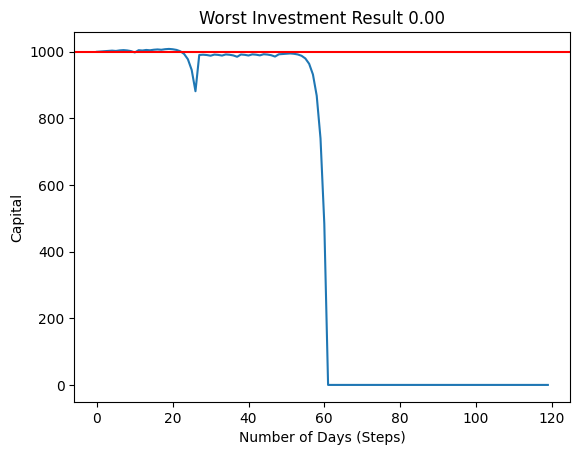

In [67]:
plt.plot(range(total_days),worst_result)
plt.axhline(y=init_capital, color='r', linestyle='-')
plt.title(f"Worst Investment Result {min(result_capital_list):.2f}")
plt.xlabel("Number of Days (Steps)")
plt.ylabel("Capital")

In [64]:
min(result_capital_list)

0

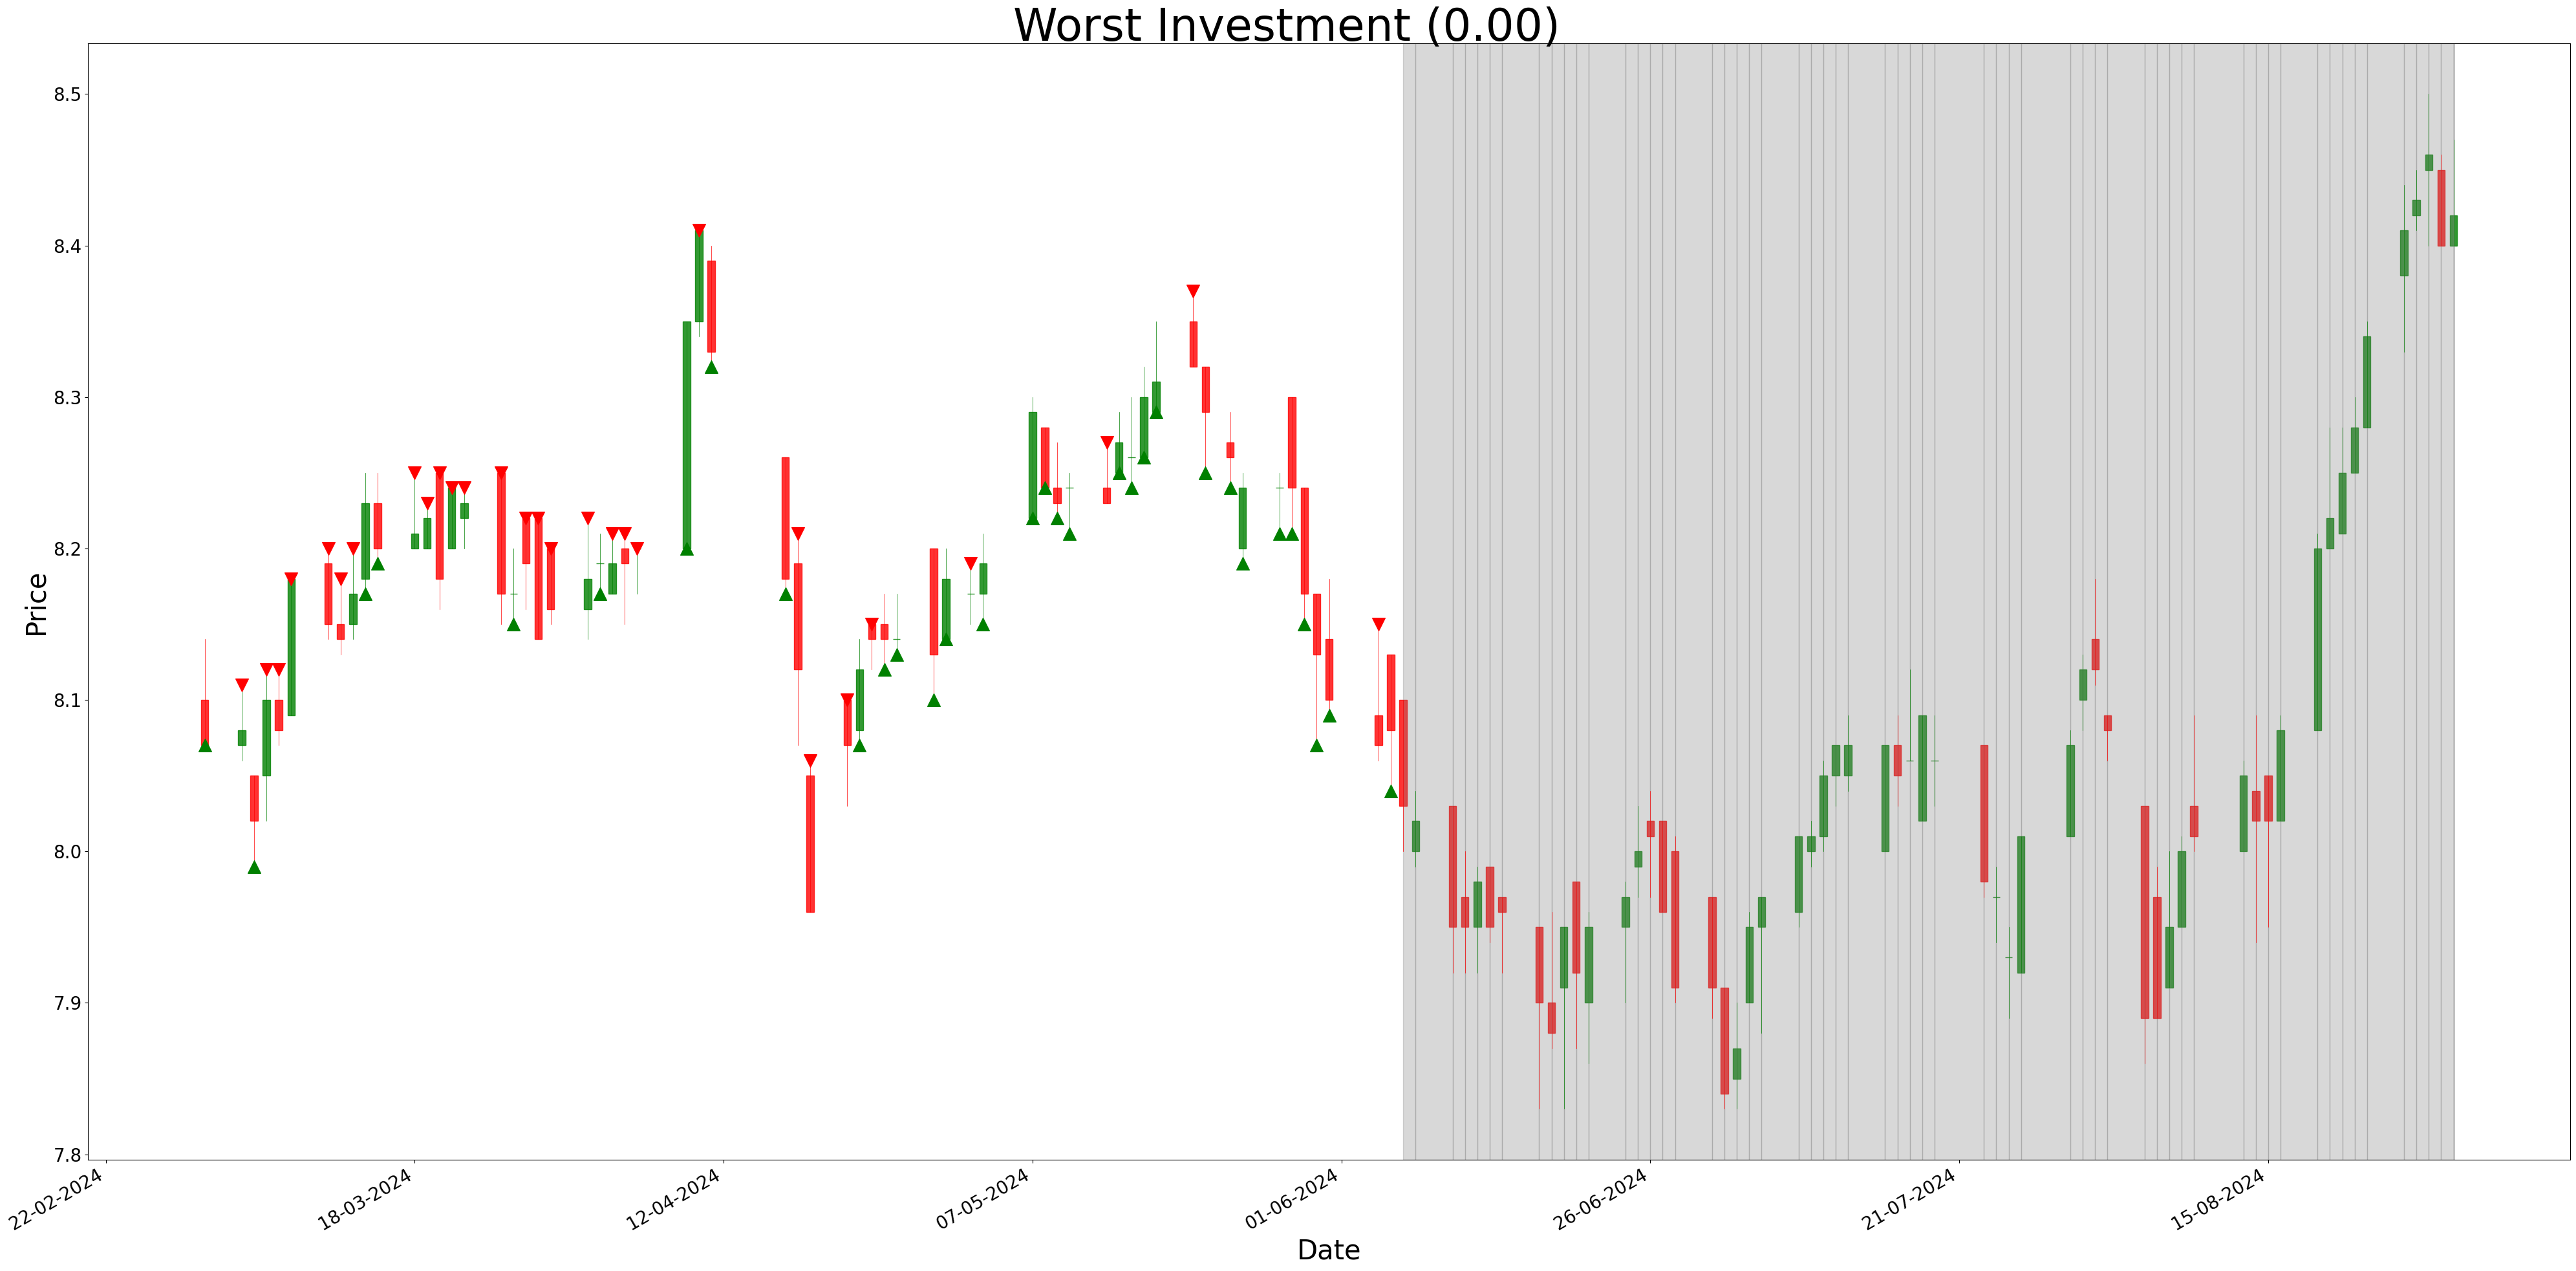

In [65]:
fig, ax = plt.subplots(figsize=(40, 20), dpi=100)

# Plotting the candlestick chart
candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Price', fontsize=30)
fig.suptitle(f'Worst Investment ({min(result_capital_list):.2f})', fontsize=50)

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

# Increase tick label size
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Adding arrows and shaded regions based on worst_guess
for i, guess in enumerate(worst_guess):
    date = ohlc['วันที่'].iloc[i]
    high = ohlc['ราคาสูงสุด'].iloc[i]
    low = ohlc['ราคาต่ำสุด'].iloc[i]

    if guess == "CALL":
        # Plot an upward green arrow below the lowest price
        # ax.annotate('', xy=(date, low), xytext=(date, low - 1),
        #             triangle=dict(facecolor='green', shrink=0.05, headwidth=20, width=3))
        ax.scatter(date, low, color='green', marker='^', s=200, zorder=5)

    elif guess == "PUT":
        # Plot a downward red arrow above the highest price
        # ax.annotate('', xy=(date, high), xytext=(date, high + 1),
        #             triangle=dict(facecolor='red', shrink=0.05, headwidth=20, width=3))
        ax.scatter(date, high, color='red', marker='v', s=200, zorder=5)

    elif guess == "-":
        # Plot a gray shaded region starting from this date
        try:
            next_date = ohlc['วันที่'].iloc[i+1]
            ax.axvspan(date, next_date, color='gray', alpha=0.3)
        except:
            ax.axvspan(date, date, color='gray', alpha=0.9)
fig.tight_layout()

# Display the plot
plt.show()